Step 1: Imports and data

In [102]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from pyproj import CRS
from geopy.geocoders import Nominatim
from shapely.geometry import Point

Step 2: Read the datasets

In [103]:
# Load snowfall data
snowfall_df = pd.read_csv("https://raw.githubusercontent.com/jswelling/CMU-MS-DAS-Vis-S25/main/data/snowstorm_PA.tsv", sep='\t')

# Load city-county mapping data
cities_counties_df = pd.read_csv("https://raw.githubusercontent.com/jswelling/CMU-MS-DAS-Vis-S25/main/data/PA_cities_counties.tsv", sep='\t')


Read the geodata files

In [104]:
# Load counties geodata
counties_gdf = gpd.read_file("tl_2021_us_county.zip")

# Load Pennsylvania municipalities geodata
municipalities_gdf = gpd.read_file("PaMunicipalities2022_01.zip")


In [105]:
# Check the first few rows of each DataFrame to confirm correct loading:
print(snowfall_df.head())


                       Location  Low End Snowfall  Expected Snowfall  \
0                   Bethel Park                 8                 12   
1                 Franklin Park                 8                 13   
2               Jefferson Hills                 7                 11   
3                   Monroeville                 7                 10   
4  Moon/Pittsburgh Intl Airport                 9                 13   

   High End Snowfall P>=0.1" P>=1" P>=2" P>=4" P>=6" P>=8" P>=12" P>=18"  
0                 15    100%  100%  100%   98%   94%   83%    40%     1%  
1                 16    100%  100%  100%   99%   96%   88%    51%     3%  
2                 14    100%  100%  100%   98%   93%   80%    31%     1%  
3                 14    100%  100%  100%   99%   94%   81%    32%     1%  
4                 16    100%  100%  100%   99%   97%   91%    56%     4%  


In [106]:
print(cities_counties_df.head())

           Name  Type        County  Class  Population (2018 Estimates)  \
0     Aliquippa  City        Beaver  Third                         8908   
1     Allentown  City        Lehigh  Third                       123828   
2       Altoona  City         Blair  Third                        43702   
3        Arnold  City  Westmoreland  Third                         4980   
4  Beaver Falls  City        Beaver  Third                         8387   

   Incorporation date (as city)  Sq Miles  
0                          1987      4.19  
1                          1867     17.55  
2                          1868      9.91  
3                          1939      0.73  
4                          1928      2.13  


In [107]:
print(counties_gdf.head())

  STATEFP COUNTYFP  COUNTYNS  GEOID       NAME          NAMELSAD LSAD CLASSFP  \
0      31      039  00835841  31039     Cuming     Cuming County   06      H1   
1      53      069  01513275  53069  Wahkiakum  Wahkiakum County   06      H1   
2      35      011  00933054  35011    De Baca    De Baca County   06      H1   
3      31      109  00835876  31109  Lancaster  Lancaster County   06      H1   
4      31      129  00835886  31129   Nuckolls   Nuckolls County   06      H1   

   MTFCC CSAFP CBSAFP METDIVFP FUNCSTAT       ALAND    AWATER     INTPTLAT  \
0  G4020  None   None     None        A  1477645345  10690204  +41.9158651   
1  G4020  None   None     None        A   680976231  61568965  +46.2946377   
2  G4020  None   None     None        A  6016818946  29090018  +34.3592729   
3  G4020   339  30700     None        A  2169272970  22847034  +40.7835474   
4  G4020  None   None     None        A  1489645185   1718484  +40.1764918   

       INTPTLON                             

In [108]:
print(municipalities_gdf.head())

   MSLINK COUNTY MUNICIPAL_    MUNICIPAL1 FIPS_MUN_C FED_AID_UR FIPS_COUNT  \
0    2254     59        209  WEST BUFFALO      82640          1        119   
1    1258     21        203      HOPEWELL      35672          1        041   
2    2255     59        210    WHITE DEER      84496          2        119   
3     283     50        407   MILLERSTOWN      49720          1        099   
4    2278     60        219    SCRUBGRASS      69016          1        121   

  FIPS_AREA_ FIPS_NAME  FIPS_SQ_MI  ...  FED_ID_NUM CLASS_OF_M  GIS_UPDATE  \
0      00000      None        38.2  ...  24-6001593       2TWP  0000/00/00   
1      00000      None        28.2  ...  23-2131817       2TWP  0000/00/00   
2      50016    MILTON        30.6  ...  24-6001596       2TWP  0000/00/00   
3      00000      None         1.2  ...  23-6050573       BORO  0000/00/00   
4      00000      None        27.4  ...  25-1377305       2TWP  0000/00/00   

   GIS_GEOMET   GPID  GEOMETRY_A  GEOMETRY_L    Shape_Leng    

Step 3: Copying Utility Functions

In [109]:
def add_area_and_label_coords(some_gdf):
    some_gdf['area'] = some_gdf.area
    some_gdf['coords'] = some_gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
    some_gdf['coords'] = [coords[0] for coords in some_gdf['coords']]

In [110]:
def plot_with_labels(some_gdf, ax, name_col=None, field_col=None, **kwargs):
    if field_col is None:
        some_gdf.plot(ax=ax, **kwargs)
    else:
        some_gdf.plot(column=field_col, ax=ax, legend=True, **kwargs)
    if name_col is not None:
        for idx, row in some_gdf.iterrows():
            ax.annotate(text=row[name_col], xy=row['coords'],
                         horizontalalignment='center')

In [111]:
def calc_overall_centroid(some_gdf):
    """
    Use the 'coords' and 'area' columns to estimate an overall centroid
    """
    sum_x = 0.0
    sum_y = 0.0
    sum_area = 0.0
    for idx, row in some_gdf.iterrows():
        coord_x, coord_y = row['coords']
        sum_x += coord_x * row['area']
        sum_y += coord_y * row['area']
        sum_area += row['area']
    centroid_x = sum_x / sum_area
    centroid_y = sum_y / sum_area
    return centroid_x, centroid_y

In [112]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees).  All args
    must be of equal length.
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

Step 4: Select Pennsylvania from GeoDataFrame

In [113]:
# Filter Pennsylvania counties using FIPS code 42:

pa_counties_gdf = counties_gdf[counties_gdf['STATEFP'] == '42'].copy()


In [114]:
print(pa_counties_gdf.head())

    STATEFP COUNTYFP  COUNTYNS  GEOID     NAME        NAMELSAD LSAD CLASSFP  \
19       42      007  01214112  42007   Beaver   Beaver County   06      H1   
47       42      053  01213669  42053   Forest   Forest County   06      H1   
95       42      117  01209189  42117    Tioga    Tioga County   06      H1   
108      42      043  01213667  42043  Dauphin  Dauphin County   06      H1   
165      42      127  01213692  42127    Wayne    Wayne County   06      H1   

     MTFCC CSAFP CBSAFP METDIVFP FUNCSTAT       ALAND    AWATER     INTPTLAT  \
19   G4020   430  38300     None        A  1125854819  24162295  +40.6841401   
47   G4020  None   None     None        A  1106595595   8369675  +41.5133040   
95   G4020  None   None     None        A  2936765818   8279717  +41.7668593   
108  G4020   276  25420     None        A  1359407363  86209037  +40.4125646   
165  G4020  None   None     None        A  1879734030  64785676  +41.6466021   

         INTPTLON                           

Step 5: Set Up an Orthographic Projection for PA

In [115]:
# Define an orthographic projection centered approximately on Pennsylvania
ortho_crs = CRS.from_proj4("+proj=ortho +lat_0=41.0 +lon_0=-77.5")  # Approx center of PA

# Convert Pennsylvania GeoDataFrame to this projection
pa_counties_gdf = pa_counties_gdf.to_crs(ortho_crs)

# Confirm CRS is set correctly
print(pa_counties_gdf.crs)


+proj=ortho +lat_0=41.0 +lon_0=-77.5 +type=crs


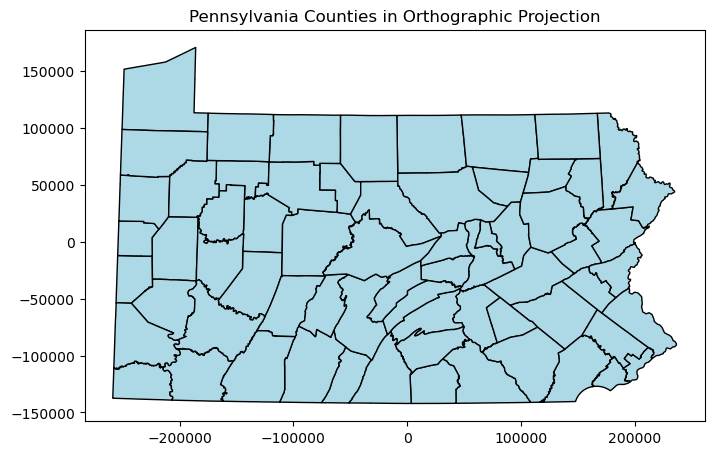

In [116]:
fig, ax = plt.subplots(figsize=(8, 8))

pa_counties_gdf.plot(edgecolor='black', color='lightblue', ax=ax)
ax.set_title("Pennsylvania Counties in Orthographic Projection")

plt.show()  # Explicitly show the plot


Step 6: Merge Snowfall Data with County Data

In [117]:
# 1. Merge snowfall data with city-county mapping dataset

merged_df = snowfall_df.merge(cities_counties_df, how='left', left_on='Location', right_on='Name')

In [118]:
merged_df.head()

,Location,Low End Snowfall,Expected Snowfall,High End Snowfall,"P>=0.1""","P>=1""","P>=2""","P>=4""","P>=6""","P>=8""","P>=12""","P>=18""",Name,Type,County,Class,Population (2018 Estimates),Incorporation date (as city),Sq Miles
0,Bethel Park,8,12,15,100%,100%,100%,98%,94%,83%,40%,1%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Franklin Park,8,13,16,100%,100%,100%,99%,96%,88%,51%,3%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Jefferson Hills,7,11,14,100%,100%,100%,98%,93%,80%,31%,1%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Monroeville,7,10,14,100%,100%,100%,99%,94%,81%,32%,1%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Moon/Pittsburgh Intl Airport,9,13,16,100%,100%,100%,99%,97%,91%,56%,4%,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [119]:
# Check if Any Cities Are Missing After the Merge

print("Total cities before merge:", len(snowfall_df))
print("Total cities after merge:", len(merged_df))


Total cities before merge: 93
Total cities after merge: 93


In [120]:
# Check for Cities with Missing County Information

missing_counties = merged_df[merged_df['County'].isna()]
print("Cities without county information:\n", missing_counties[['Location', 'Expected Snowfall']])


Cities without county information:
                         Location  Expected Snowfall
0                    Bethel Park                 12
1                  Franklin Park                 13
2                Jefferson Hills                 11
3                    Monroeville                 10
4   Moon/Pittsburgh Intl Airport                 13
..                           ...                ...
82                        Donora                 10
84                       Donegal                 11
86                      Jeanette                  9
88                     Ligonier                   9
91                   Murrysville                 10

[77 rows x 2 columns]


In [121]:
#  2. Fill missing counties using Nominatim Geocoder

import time
# Initialize the geocoder
geolocator = Nominatim(user_agent="pa_snowfall")

# Function to fetch county name from a location
def get_county(location):
    try:
        # Query location in Pennsylvania, USA
        place = geolocator.geocode(f"{location}, Pennsylvania, US", timeout=10)
        if place:
            address = place.address
            # Split the address into parts and find the county
            for part in address.split(","):
                if "County" in part:
                    return part.strip().split()[0]  # Extract first word (county name)
        return None
    except Exception as e:
        print(f"Error fetching {location}: {e}")
        return None

# Apply the function only to rows where County is missing
for index, row in merged_df[merged_df['County'].isna()].iterrows():
    county_name = get_county(row['Location'])
    if county_name:
        merged_df.at[index, 'County'] = county_name
    time.sleep(1)  # Add delay to avoid rate-limiting


In [122]:
# Verify the Updated Data
print("Updated Missing Counties:\n", merged_df[merged_df['County'].isna()])


Updated Missing Counties:
                        Location  Low End Snowfall  Expected Snowfall  \
4  Moon/Pittsburgh Intl Airport                 9                 13   

   High End Snowfall P>=0.1" P>=1" P>=2" P>=4" P>=6" P>=8" P>=12" P>=18" Name  \
4                 16    100%  100%  100%   99%   97%   91%    56%     4%  NaN   

  Type County Class  Population (2018 Estimates)  \
4  NaN    NaN   NaN                          NaN   

   Incorporation date (as city)  Sq Miles  
4                           NaN       NaN  


In [123]:
merged_df['Location'] = merged_df['Location'].replace({
    'Moon/Pittsburgh Intl Airport': 'Moon Township',
})


In [124]:
#  3. Group by county and compute mean snowfall

county_snowfall = merged_df.groupby("County")['Expected Snowfall'].mean().reset_index()


In [125]:
#  4. Merge snowfall data into the GeoDataFrame

pa_counties_gdf = pa_counties_gdf.merge(county_snowfall, left_on='NAME', right_on='County', how='left')


In [126]:
pa_counties_gdf.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,County,Expected Snowfall
0,42,007,01214112,42007,Beaver,Beaver County,06,H1,G4020,430,38300,None,A,1125854819,24162295,+40.6841401,-080.3507209,"POLYGON ((-235266.344 -47702.061, -236441.178 ...",Beaver,12.4
1,42,053,01213669,42053,Forest,Forest County,06,H1,G4020,None,None,None,A,1106595595,8369675,+41.5133040,-079.2497050,"POLYGON ((-121726.592 59376.359, -121727.837 5...",Forest,12.0
2,42,117,01209189,42117,Tioga,Tioga County,06,H1,G4020,None,None,None,A,2936765818,8279717,+41.7668593,-077.2572881,"POLYGON ((24063.852 60615.496, 24049.252 60615...",NaN,NaN
3,42,043,01213667,42043,Dauphin,Dauphin County,06,H1,G4020,276,25420,None,A,1359407363,86209037,+40.4125646,-076.7926343,"POLYGON ((77231.298 -82405.998, 77234.293 -824...",NaN,NaN
4,42,127,01213692,42127,Wayne,Wayne County,06,H1,G4020,None,None,None,A,1879734030,64785676,+41.6466021,-075.2924932,"POLYGON ((184159.158 43124.051, 184146.36 4313...",NaN,NaN


In [127]:
missing_snowfall = pa_counties_gdf[pa_counties_gdf['Expected Snowfall'].isna()]
print(missing_snowfall[['County', 'Expected Snowfall']])


   County  Expected Snowfall
2     NaN                NaN
3     NaN                NaN
4     NaN                NaN
7     NaN                NaN
11    NaN                NaN
12    NaN                NaN
14    NaN                NaN
15    NaN                NaN
16    NaN                NaN
18    NaN                NaN
20    NaN                NaN
21    NaN                NaN
22    NaN                NaN
24    NaN                NaN
25    NaN                NaN
26    NaN                NaN
27    NaN                NaN
28    NaN                NaN
29    NaN                NaN
30    NaN                NaN
31    NaN                NaN
32    NaN                NaN
33    NaN                NaN
34    NaN                NaN
35    NaN                NaN
36    NaN                NaN
37    NaN                NaN
39    NaN                NaN
40    NaN                NaN
41    NaN                NaN
42    NaN                NaN
43    NaN                NaN
44    NaN                NaN
45    NaN     

Step 7: Plot the Snowfall Map

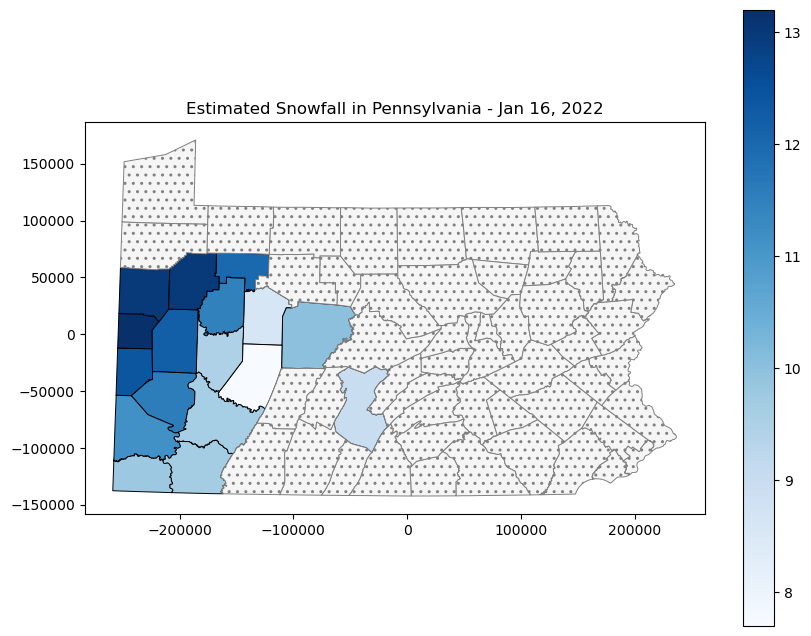

In [128]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plot the counties with snowfall data
pa_counties_gdf.plot(
    column="Expected Snowfall",  # Use Expected Snowfall for color mapping
    cmap="Blues",  # Choose a color map (try "coolwarm", "viridis", etc.)
    legend=True,  
    edgecolor="black",
    linewidth=0.7,  
    missing_kwds={  # Styling for missing data
        "color": "whitesmoke",  # Fill missing counties with light grey
        "edgecolor": "gray",  # Outline them in red
        "hatch": "..",  # Add a hatch pattern
        "label": "No Data",  # Legend label for missing values
    },
    ax=ax,
)

plt.title("Estimated Snowfall in Pennsylvania - Jan 16, 2022")
plt.show()

Step 8: Prepare for Travel Distance Calculation

In [129]:
print(municipalities_gdf.columns)


Index(['MSLINK', 'COUNTY', 'MUNICIPAL_', 'MUNICIPAL1', 'FIPS_MUN_C',
       'FED_AID_UR', 'FIPS_COUNT', 'FIPS_AREA_', 'FIPS_NAME', 'FIPS_SQ_MI',
       'FIPS_MUN_P', 'FED_ID_NUM', 'CLASS_OF_M', 'GIS_UPDATE', 'GIS_GEOMET',
       'GPID', 'GEOMETRY_A', 'GEOMETRY_L', 'Shape_Leng', 'Shape_Area',
       'geometry'],
      dtype='object')


In [130]:
# Filter only the cities in the travel loop
travel_towns = ['PITTSBURGH',
                'SCRANTON',
        'ALLENTOWN',
        'PHILADELPHIA',
        'HARRISBURG',
        'PITTSBURGH']
travel_gdf = municipalities_gdf[municipalities_gdf['MUNICIPAL1'].isin(travel_towns)]



In [131]:
# Check the current CRS
print("Original CRS:", travel_gdf.crs)

Original CRS: EPSG:3857


In [132]:
# Define projections
ortho_crs = CRS.from_proj4("+proj=ortho +lat_0=40.5 +lon_0=-77.0")  # Approx center of PA
platte_carree_crs = CRS.from_epsg(4326)  # Latitude/Longitude projection

In [133]:
# Reproject to Orthographic projection
travel_gdf_ortho = travel_gdf.to_crs(ortho_crs)

# Reproject to Platte Carree projection
travel_gdf_pc = travel_gdf.to_crs(platte_carree_crs)

In [137]:
# Function to add centroid coordinates
def add_area_and_label_coords(gdf):
    gdf["centroid"] = gdf.geometry.centroid
    gdf["label_x"] = gdf.centroid.x
    gdf["label_y"] = gdf.centroid.y

# Add centroid coordinates to both projections
add_area_and_label_coords(travel_gdf_ortho)
add_area_and_label_coords(travel_gdf_pc)

# Display the transformed GeoDataFrames
print(travel_gdf_ortho[['MUNICIPAL1', 'centroid']])


        MUNICIPAL1                       centroid
79      PITTSBURGH  POINT (-252407.914 -2440.685)
346     HARRISBURG    POINT (9881.644 -24956.797)
701       SCRANTON   POINT (111635.99 101275.538)
1568  PHILADELPHIA   POINT (159283.856 -52994.85)
2145     ALLENTOWN   POINT (129028.808 11800.633)


/var/folders/nr/8qbxkfps4xgblznwl9hs6yjc0000gn/T/ipykernel_29250/2583774009.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["centroid"] = gdf.geometry.centroid
/var/folders/nr/8qbxkfps4xgblznwl9hs6yjc0000gn/T/ipykernel_29250/2583774009.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["label_x"] = gdf.centroid.x
/var/folders/nr/8qbxkfps4xgblznwl9hs6yjc0000gn/T/ipykernel_29250/2583774009.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["label_y"] = gdf.centroid.y


Step 9: Plot Travel Map

In [138]:
travel_gdf_ortho

,MSLINK,COUNTY,MUNICIPAL_,MUNICIPAL1,FIPS_MUN_C,FED_AID_UR,FIPS_COUNT,FIPS_AREA_,FIPS_NAME,FIPS_SQ_MI,...,GEOMETRY_A,GEOMETRY_L,Shape_Leng,Shape_Area,geometry,area,coords,centroid,label_x,label_y
79,2140,02,301,PITTSBURGH,61000,4,003,00009,PITTSBURGH,58.2,...,0.0,0.0,161680.100738,2.609306e+08,"POLYGON ((-260427.272 234.883, -260396.981 227...",1.508653e+08,"(-251910.6849863528, -3441.473850705421)",POINT (-252407.914 -2440.685),-252407.913997,-2440.685214
346,1212,22,301,HARRISBURG,32800,4,043,00083,HARRISBURG,11.6,...,0.0,0.0,44248.628005,5.200551e+07,"POLYGON ((13642.144 -26797.819, 13617.371 -267...",3.023794e+07,"(8737.601500826442, -24207.87070682898)",POINT (9881.644 -24956.797),9881.643710,-24956.796764
701,852,35,302,SCRANTON,69000,4,069,00281,SCRAN/WLKS-BARRE,26.0,...,0.0,0.0,70454.442512,1.172628e+08,"POLYGON ((109411.386 97631.204, 109193.671 978...",6.589438e+07,"(112039.95408816446, 101376.7140184797)",POINT (111635.99 101275.538),111635.990314,101275.538227
1568,2573,67,301,PHILADELPHIA,60000,4,101,00004,PHILADELPHIA,143.0,...,0.0,0.0,157206.179534,6.297380e+08,"POLYGON ((169757.063 -51193.436, 169735.907 -5...",3.689004e+08,"(158995.3461916531, -53498.932804993485)",POINT (159283.856 -52994.85),159283.856352,-52994.850169
2145,703,39,301,ALLENTOWN,02000,4,077,00068,LEHIGH VALLEY,18.3,...,0.0,0.0,81221.859145,8.098603e+07,"POLYGON ((126916.505 13674.856, 127034.523 137...",4.663539e+07,"(128607.57406427123, 11468.588086864813)",POINT (129028.808 11800.633),129028.807879,11800.633038


/var/folders/nr/8qbxkfps4xgblznwl9hs6yjc0000gn/T/ipykernel_29250/1612280704.py:25: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/nr/8qbxkfps4xgblznwl9hs6yjc0000gn/T/ipykernel_29250/1612280704.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


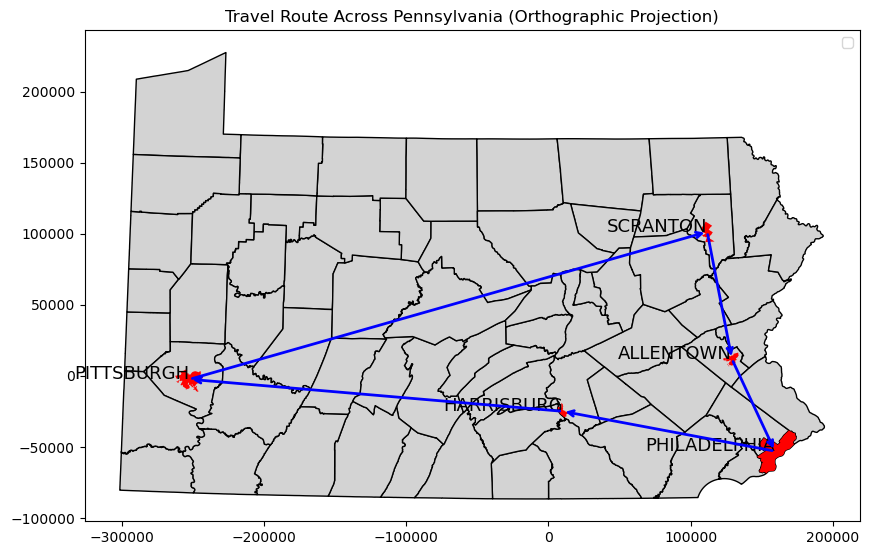

In [ ]:
# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot Pennsylvania counties in the orthographic projection
pa_counties_gdf.to_crs(ortho_crs).plot(ax=ax, color="lightgrey", edgecolor="black")

# Plot the travel cities in the orthographic projection
travel_gdf_ortho.plot(ax=ax, color="red", markersize=50, label="Travel Cities")

# Add labels to the cities using their centroids
for idx, row in travel_gdf_ortho.iterrows():
    plt.text(row.label_x, row.label_y, row['MUNICIPAL1'], fontsize=13, ha='right', color="black")

# Draw arrows between the cities to represent the travel route
for i in range(len(travel_towns) - 1):  
    start = travel_gdf_ortho[travel_gdf_ortho['MUNICIPAL1'] == travel_towns[i]].centroid.iloc[0]  
    end = travel_gdf_ortho[travel_gdf_ortho['MUNICIPAL1'] == travel_towns[i+1]].centroid.iloc[0]  
    ax.annotate("", xy=(end.x, end.y), xytext=(start.x, start.y),
                arrowprops=dict(arrowstyle="->", lw=2, color='blue'))


# Title and legend
plt.title("Travel Route Across Pennsylvania (Orthographic Projection)")
plt.legend()
plt.show()


Step 10: Compute Travel Distances

In [163]:
print(travel_gdf_ortho[['MUNICIPAL1', 'centroid', 'coords']].head())

        MUNICIPAL1                       centroid  \
79      PITTSBURGH  POINT (-252407.914 -2440.685)   
346     HARRISBURG    POINT (9881.644 -24956.797)   
701       SCRANTON   POINT (111635.99 101275.538)   
1568  PHILADELPHIA   POINT (159283.856 -52994.85)   
2145     ALLENTOWN   POINT (129028.808 11800.633)   

                                         coords  
79    (-252407.91399727878, -2440.685213874251)  
346     (9881.64371020029, -24956.796764083294)  
701      (111635.990313666, 101275.53822713038)  
1568   (159283.85635248452, -52994.85016871732)  
2145   (129028.80787924277, 11800.633037751535)  


In [164]:
# **Calculate distances in Ortho Projection (Euclidean)**
# Ensure DataFrame has required columns
travel_gdf_ortho["coords"] = travel_gdf_ortho.centroid.apply(lambda p: (p.x, p.y))
travel_gdf_ortho["area"] = travel_gdf_ortho.geometry.area

# Extract centroids in ortho projection
travel_centroids_ortho = travel_gdf_ortho.set_index("MUNICIPAL1").centroid

# Compute total Euclidean travel distance in ortho projection (including return to Pittsburgh)
total_distance_ortho = sum(
    travel_centroids_ortho.iloc[i].distance(travel_centroids_ortho.iloc[i + 1])
    for i in range(len(travel_centroids_ortho) - 1)
)

# Add final leg back to Pittsburgh (first city)
total_distance_ortho += travel_centroids_ortho.iloc[-1].distance(travel_centroids_ortho.iloc[0])

print(f"Total Euclidean travel distance (Ortho Projection): {total_distance_ortho / 1000:.2f} km")

# **Calculate distances in Platte Carree Projection (Haversine)**
# Ensure DataFrame has required columns
travel_gdf_pc["coords"] = travel_gdf_pc.centroid.apply(lambda p: (p.x, p.y))
travel_gdf_pc["area"] = travel_gdf_pc.geometry.area

# Extract centroids in lat/lon
travel_centroids_pc = travel_gdf_pc.set_index("MUNICIPAL1").centroid
latitudes = [travel_centroids_pc.iloc[i].y for i in range(len(travel_centroids_pc))]
longitudes = [travel_centroids_pc.iloc[i].x for i in range(len(travel_centroids_pc))]

# Compute total travel distance using Haversine formula (including return to Pittsburgh)
total_distance_haversine = sum(
    haversine_np(longitudes[i], latitudes[i], longitudes[i + 1], latitudes[i + 1])
    for i in range(len(travel_centroids_pc) - 1)
)

# Add final leg back to Pittsburgh (first city)
total_distance_haversine += haversine_np(longitudes[-1], latitudes[-1], longitudes[0], latitudes[0])

print(f"Total Haversine travel distance (Platte Carree Projection): {total_distance_haversine:.2f} km")


Total Euclidean travel distance (Ortho Projection): 1040.07 km
Total Haversine travel distance (Platte Carree Projection): 1038.14 km


/var/folders/nr/8qbxkfps4xgblznwl9hs6yjc0000gn/T/ipykernel_29250/3954583934.py:22: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  travel_gdf_pc["coords"] = travel_gdf_pc.centroid.apply(lambda p: (p.x, p.y))
/var/folders/nr/8qbxkfps4xgblznwl9hs6yjc0000gn/T/ipykernel_29250/3954583934.py:23: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  travel_gdf_pc["area"] = travel_gdf_pc.geometry.area
/var/folders/nr/8qbxkfps4xgblznwl9hs6yjc0000gn/T/ipykernel_29250/3954583934.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  travel_centroids_pc = travel_gdf_pc.set_index("MUNICIPAL1").centr

The difference in the total travel distances between the Euclidean distance (Ortho Projection) and Haversine distance (Platte Carree Projection) is expected due to the fundamental differences between these two methods of calculating distance. Here's an explanation of why the values might differ:

1. Nature of the Distance Calculation Methods:

- Euclidean Distance (Ortho Projection):
This method calculates the straight-line distance between two points in a flat plane, assuming no curvature of the Earth. It's based on Cartesian coordinates, where distances are computed in a straight line.
Limitation: The Euclidean method works well in projections where the curvature of the Earth can be ignored, but it's not accurate for large distances or on the Earth's surface.

- Haversine Distance (Platte Carree Projection): 
This method calculates the great-circle distance between two points on the surface of a sphere (the Earth) using their latitudes and longitudes.
It accounts for the curvature of the Earth and provides a more accurate result for large distances over the globe.
Limitation: Haversine is an approximation because the Earth is not a perfect sphere, but it generally works well for distances on the Earth's surface.


2. Projection Differences:
Ortho Projection (Euclidean) is a local projection that flattens the Earth's surface (which is spherical) into a plane. This can cause distortion, especially over larger areas or when working with global-scale distances. The farther apart the points are, the more significant the distortion will be.
Platte Carree Projection (used for Haversine distance) is a global projection that maps the spherical surface of the Earth onto a flat plane using longitude and latitude. However, this projection distorts areas and distances, especially near the poles. The Haversine formula compensates for this by accounting for the Earth's curvature, making it more accurate for calculating large distances.

3. Distance on a Flat Plane vs. Spherical Surface:
In the Euclidean calculation, distances are computed as if the Earth is flat (ignoring curvature). For small areas, this can work fine, but as you move farther apart (especially when distances span significant latitudes/longitudes), the errors in Euclidean calculations accumulate.
The Haversine method takes Earth's curvature into account. For larger distances (especially those spanning wide latitudes and longitudes), it gives a more accurate representation of the true distance.

4. Effect of Projections on the Distance:
Ortho Projection typically performs well for smaller areas and regions close to the projection's central meridian, but the farther the locations are from the center, the more distorted their distances become.
Platte Carree Projection (although a simple projection) is also not perfect, but it treats distances with the Earth's curvature in mind, making it more reliable for global-scale distances.
In your case, the distances are close (1040.07 km vs. 1038.14 km), but they are different due to the fact that one method is "flat" (Euclidean) and the other is "curved" (Haversine).



Conclusion:
The difference in total distances (1040.07 km vs. 1038.14 km) is due to the fundamental difference in how the distances are computed:

Euclidean distance (Ortho Projection) assumes flat, straight lines and ignores the Earth's curvature, which leads to slightly different results for large distances.
Haversine distance (Platte Carree Projection) takes the Earth's curvature into account, leading to more accurate results for longer distances, especially when working on a global scale.